## Imports

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from dataclasses import dataclass, asdict


## Read data


In [2]:
@dataclass
class Exp_Sample:
    user_id: int
    age: int
    gender: str
    skill: int
    path: str
    ear_id: str
    ear_view_pos: int
    method: str
    first_img: bool = True
    total_time: int = 0
    sam1_proposed_am: int = 0
    sam2_proposed_am: int = 0
    sam1_interactive_am: int = 0
    sam2_interactive_am: int = 0
    polygon_drawing_am: int = 0
    sam2_tracking_am: int = 0
    panorama_tracking_am: int = 0
    total_masks_am: int = 0
    sam1_proposed_sm: int = 0
    sam2_proposed_sm: int = 0
    sam1_interactive_sm: int = 0
    sam2_interactive_sm: int = 0
    polygon_drawing_sm: int = 0
    sam2_tracking_sm: int = 0
    panorama_tracking_sm: int = 0
    total_masks_sm: int = 0

@dataclass
class Exp_Mask:
    user_id: int
    path: str
    ear_id: str
    ear_view_pos: int
    method: str
    first_img: bool 
    tool: str
    time_stamp: int 
    time_delta: int = 0

class SampleInfoPerUser:
    def __init__(self, path:str, user_id:int):
        self.user_dir = path
        self.dir_paths = glob.glob(path + "/*")
        self.user_id = user_id

    def __call__(self):
        img_dirs = [item for item in self.dir_paths if os.path.isdir(item)]
        self.exp_samples = [self.get_path_information(path, self.user_id) for path in img_dirs]
        self.exp_samples, self.samlpe_pairs = self.find_sample_pairs(self.exp_samples)
        self.exp_samples = [self.get_log_info(sample) for sample in self.exp_samples]
        return self.exp_samples

    def get_path_information(self, path:str, user_id:int):
        base_name = os.path.basename(path)
        splits = base_name.split('_')
        for i, sub_split in enumerate(splits):
            if 'low' in sub_split:
                ear_view_pos = splits[i+1]
                break
        ear_id = splits[0]
        if "polygon" in base_name:
            method = "polygon"
        elif "sam1" in base_name :
            method = "sam1"
        elif "sam2" in base_name:
            method = "sam2"
        age, gender, skills = self.get_user_info()
        exp_sample = Exp_Sample(user_id, age, gender, skills, path, ear_id, ear_view_pos, method)
        return exp_sample
    
    def get_user_info(self):
        with open (os.path.join(self.user_dir, "user_information.json")) as f:
            user_info = json.load(f)
        return user_info["age"], user_info["gender"], user_info["skills"]

    def find_sample_pairs(self, exp_samples: list[Exp_Sample]):
        sample_pairs = []
        sample_paths_done = []
        for exp_sample1 in exp_samples:
            for exp_sample2 in exp_samples:
                if exp_sample1.ear_id == exp_sample2.ear_id and exp_sample1.method == exp_sample2.method:
                    if not exp_sample1 == exp_sample2:
                        if not exp_sample1.path in sample_paths_done and not exp_sample2.path in sample_paths_done:
                            sample_paths_done.append(exp_sample1.path)
                            sample_paths_done.append(exp_sample2.path)
                            self.find_first_imgs(exp_sample1, exp_sample2)
                            sample_pairs.append((exp_sample1, exp_sample2))
        return exp_samples, sample_pairs

    def find_first_imgs(self, sample1, sample2):
        if sample1.ear_view_pos > sample2.ear_view_pos:
            sample1.first_img = True
            sample2.first_img = False
        elif sample1.ear_view_pos < sample2.ear_view_pos:
            sample1.first_img = False
            sample2.first_img = True

    def get_log_info(self, sample: Exp_Sample):
        log_p = sample.path + "/log.json"
        if not os.path.exists(log_p):
            raise FileNotFoundError(f"Log file not found in {log_p}")
        with open(log_p) as f:
            log = json.load(f)

        sample.total_time = log["Total_time"]
        sample.sam1_proposed_am = log["All_masks"]["Sam1_proposed"]
        sample.sam2_proposed_am = log["All_masks"]["Sam2_proposed"]
        sample.sam1_interactive_am = log["All_masks"]["Sam1_interactive"]
        sample.sam2_interactive_am = log["All_masks"]["Sam2_interactive"]
        sample.polygon_drawing_am = log["All_masks"]["Polygon_drawing"]
        sample.sam2_tracking_am = log["All_masks"]["Sam2_tracking"]
        sample.panorama_tracking_am = log["All_masks"]["Panorama_tracking"]
        sample.total_masks_am = log["All_masks"]["Total_masks"]
        sample.sam1_proposed_sm = log["Selected_masks"]["Sam1_proposed"]
        sample.sam2_proposed_sm = log["Selected_masks"]["Sam2_proposed"]
        sample.sam1_interactive_sm = log["Selected_masks"]["Sam1_interactive"]
        sample.sam2_interactive_sm = log["Selected_masks"]["Sam2_interactive"]
        sample.polygon_drawing_sm = log["Selected_masks"]["Polygon_drawing"]
        sample.sam2_tracking_sm = log["Selected_masks"]["Sam2_tracking"]
        sample.panorama_tracking_sm = log["Selected_masks"]["Panorama_tracking"]
        sample.total_masks_sm = log["Selected_masks"]["Total_masks"]
        return sample
    
class MaskInfoPerUser:
    def __init__(self, samples: list[Exp_Sample]):
        self.samples = samples
        print(self.samples)
        self.prev_ts = 0
        self.exp_masks = []

    def __call__(self):

        for sample in self.samples:
            sample_p = sample.path
            mask_dirs = glob.glob(sample_p + "/masks/*")
            exp_masks = [self.read_mask_name(mask_path, sample) for mask_path in mask_dirs]
            exp_masks = sorted(exp_masks, key=lambda x: int(x.time_stamp))
            exp_masks = [self.get_time_delta(mask) for mask in exp_masks]
            
            
            self.exp_masks.extend(exp_masks)
        
                
            self.prev_ts = 0  
        return self.exp_masks

    def read_mask_name(self, mask_path:str, sample:Exp_Sample):
        mask_name = os.path.basename(mask_path)
        name_splits = mask_name.split('_')
        time_stamp = name_splits[2]
        tool = name_splits[1]
        exp_mask = Exp_Mask(sample.user_id, sample.path, sample.ear_id, sample.ear_view_pos, sample.method, sample.first_img, tool, time_stamp)
        return exp_mask

    def get_time_delta(self, exp_mask: Exp_Mask):
        if exp_mask.method == "polygon":
            exp_mask.time_delta = int(exp_mask.time_stamp)
        else:
            exp_mask.time_delta = int(exp_mask.time_stamp) - self.prev_ts
            self.prev_ts = int(exp_mask.time_stamp)
        return exp_mask
        

In [3]:
exp_result_dirs = glob.glob(r"C:\Users\geink81\Desktop\ARAMSAM_UserExperiment/*")
samples_list = []
mask_info_list = []

for user_result_dir in exp_result_dirs:
    user_id = os.path.basename(user_result_dir).split("_")[-1]
    samples = SampleInfoPerUser(user_result_dir, user_id)
    sample_info = samples()
    masks = MaskInfoPerUser(sample_info)
    samples_list.extend(sample_info)
    mask_info_list.extend(masks())

print(samples_list[0])
df_sample = pd.DataFrame([asdict(sample) for sample in samples_list])
df_mask = pd.DataFrame([asdict(mask) for mask in mask_info_list])


df_sample["ds_per_mask"] = df_sample.loc[:, "total_time"] / df_sample.loc[:, "total_masks_sm"]
df_sample["user_img"] = df_sample.loc[:, "user_id"].astype(str) + "-" + df_sample.loc[:, "ear_id"] 
print(df_sample.keys())
print(df_sample["user_img"])
print(df_mask.describe())

#df_mask.to_csv("test.csv", index = False)
#df_sample.to_csv("sample_test.csv", index=False)




[Exp_Sample(user_id='0', age=26, gender='Male', skill=7, path='C:\\Users\\geink81\\Desktop\\ARAMSAM_UserExperiment\\User_0\\39320223493024_low_192_annots_structured_sam1', ear_id='39320223493024', ear_view_pos='192', method='sam1', first_img=False, total_time=3362, sam1_proposed_am=120, sam2_proposed_am=0, sam1_interactive_am=3, sam2_interactive_am=0, polygon_drawing_am=0, sam2_tracking_am=0, panorama_tracking_am=68, total_masks_am=191, sam1_proposed_sm=50, sam2_proposed_sm=0, sam1_interactive_sm=3, sam2_interactive_sm=0, polygon_drawing_sm=0, sam2_tracking_sm=0, panorama_tracking_sm=40, total_masks_sm=93), Exp_Sample(user_id='0', age=26, gender='Male', skill=7, path='C:\\Users\\geink81\\Desktop\\ARAMSAM_UserExperiment\\User_0\\39320223493024_low_192_annots_structured_sam2', ear_id='39320223493024', ear_view_pos='192', method='sam2', first_img=False, total_time=748, sam1_proposed_am=0, sam2_proposed_am=129, sam1_interactive_am=0, sam2_interactive_am=0, polygon_drawing_am=0, sam2_tracki

## Statistics

### Plotting

In [4]:
def get_violin_plot(df, xkey, ykey, colour_key):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(dpi=200)
    sns.violinplot(data=df, x=xkey, y=ykey, hue=colour_key, color='#2fb2b2') # Smart agricultural technology color "#2fb2b2"
    plt.show()
    

def get_box_plot(df, xkey, ykey, colour_key):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(dpi=200)
    sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, color='#2fb2b2')
    plt.show()

def get_swarm_plot(df, xkey, ykey, colour_key):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(dpi=200)
    sns.swarmplot(data=df, x=xkey, y=ykey, hue=colour_key)
    plt.show()

Mean time per mask over all images and users
Polygon
96.29059829059828
Sam1
27.212630386958935
Sam2
22.325521397758575
-------------------

All methods, first img, Mean per img, Violoin Plot


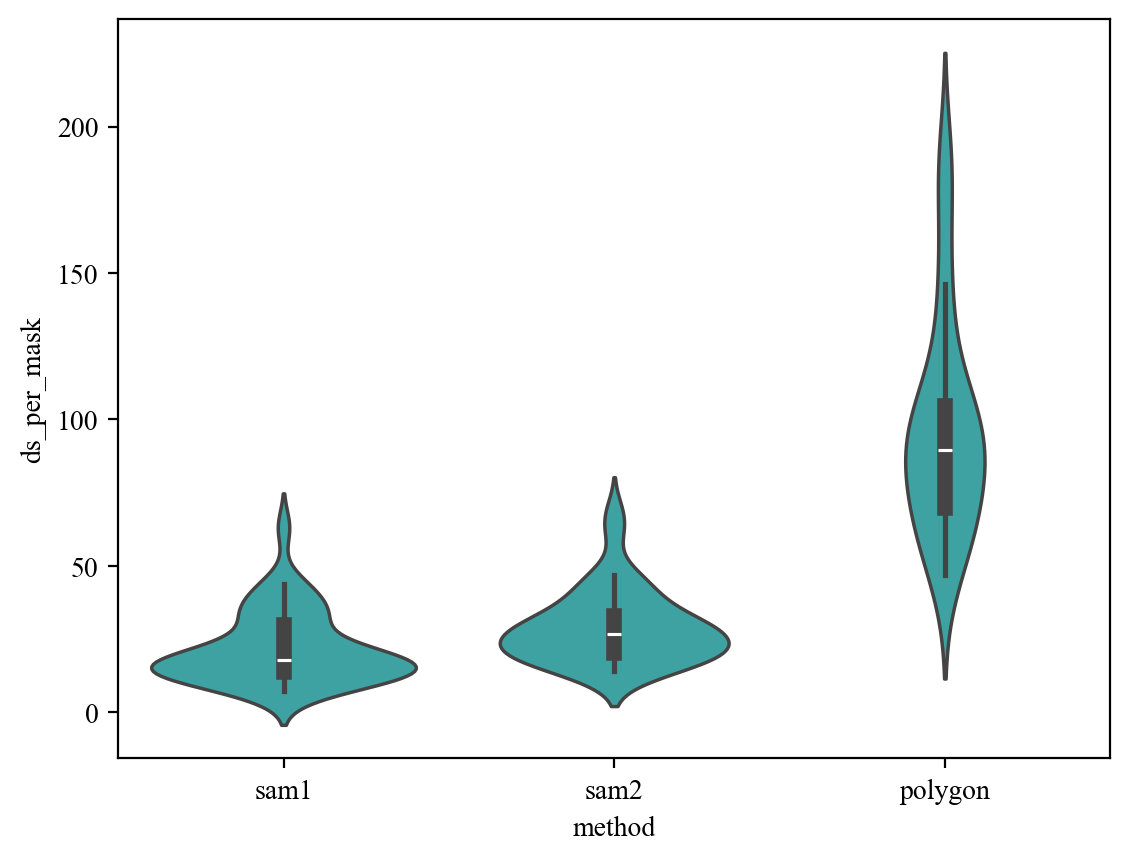

All methods, first img, Mean per img, Box Plot


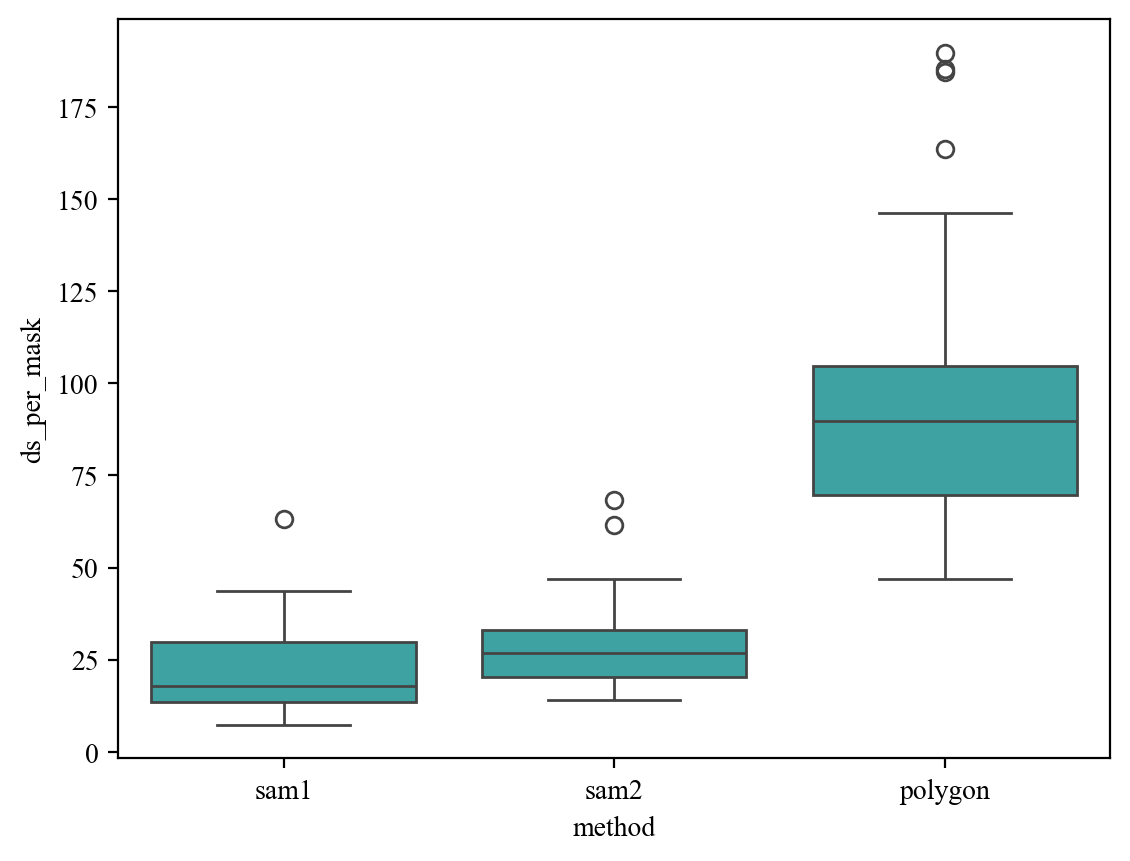

All methods, first img, Mean per img, Swarm Plot


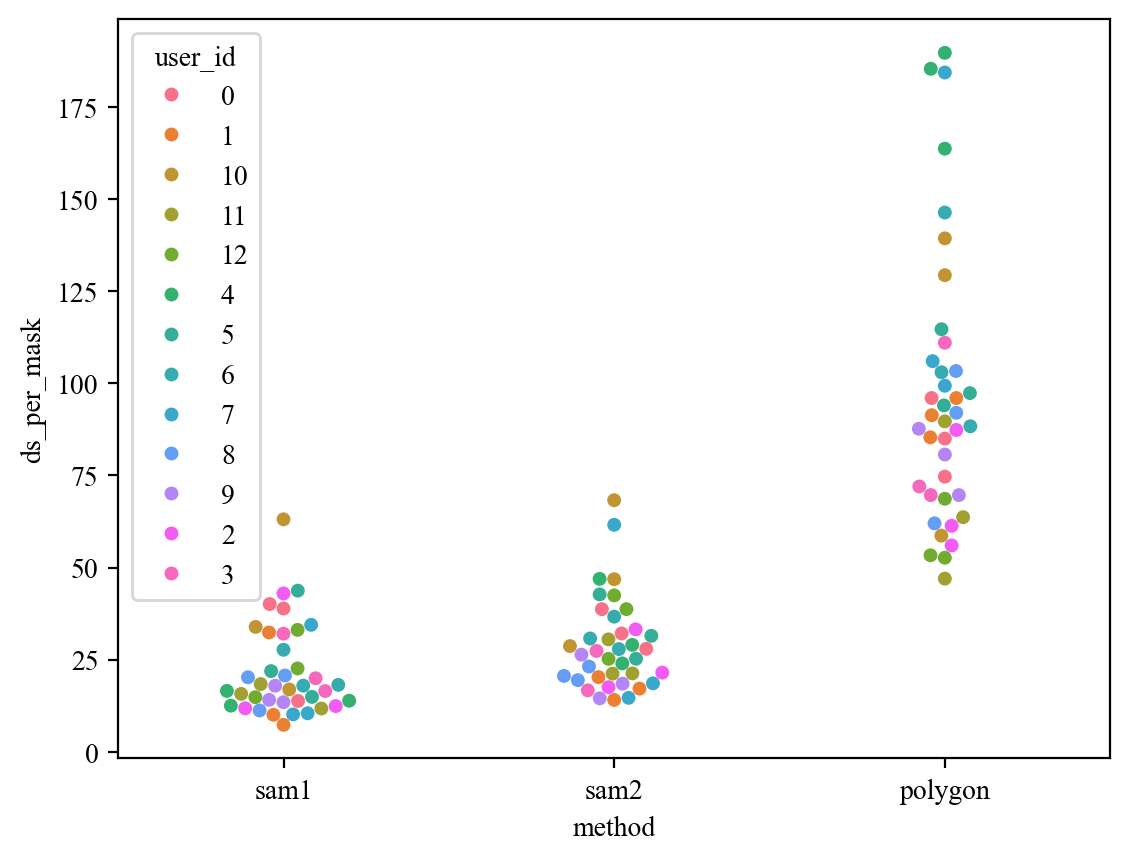

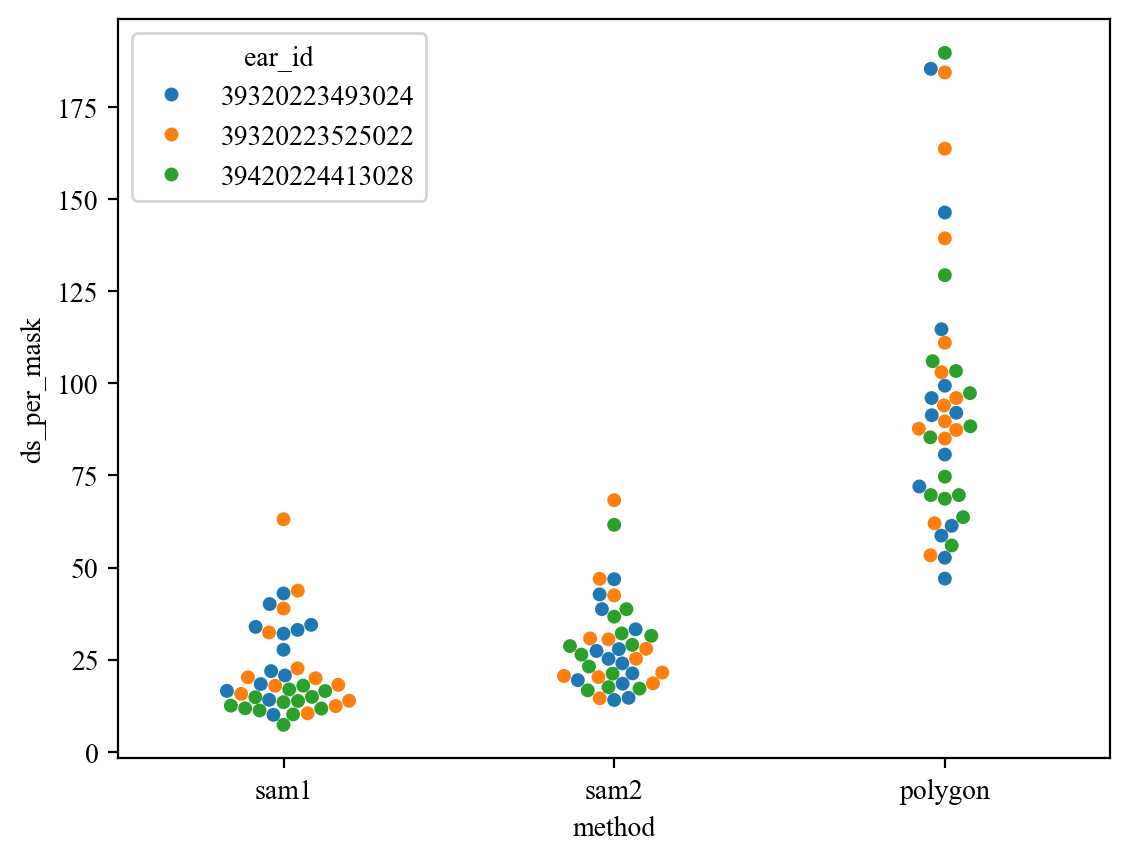

All methods, first img, All  masks, Violoin Plot


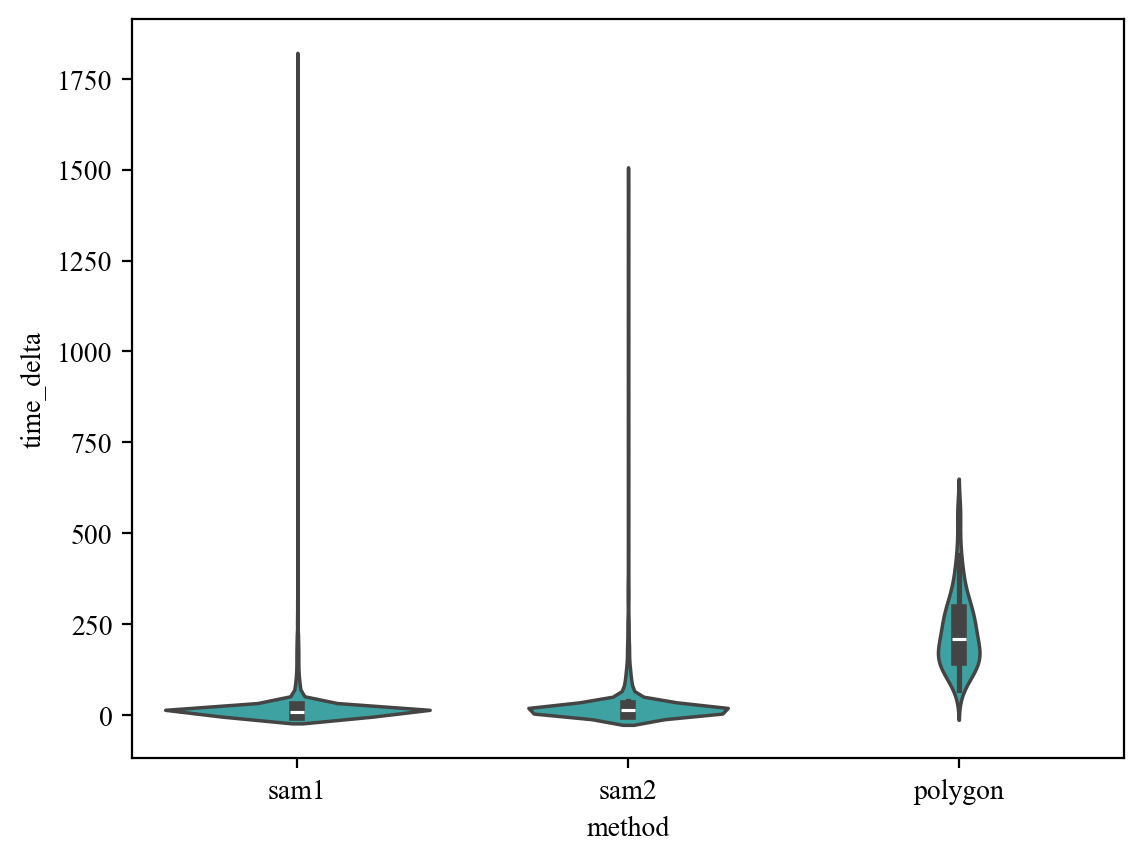

All methods, first img, All  masks, Box Plot


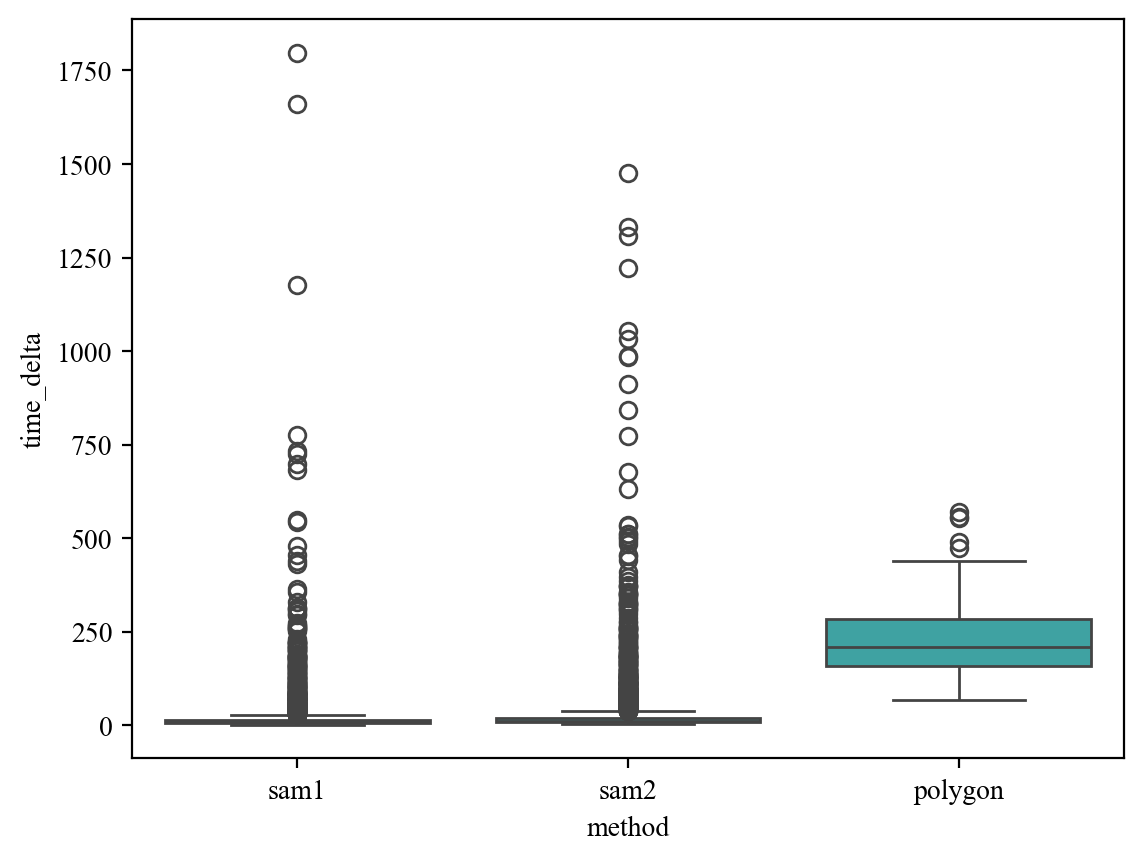

First Image


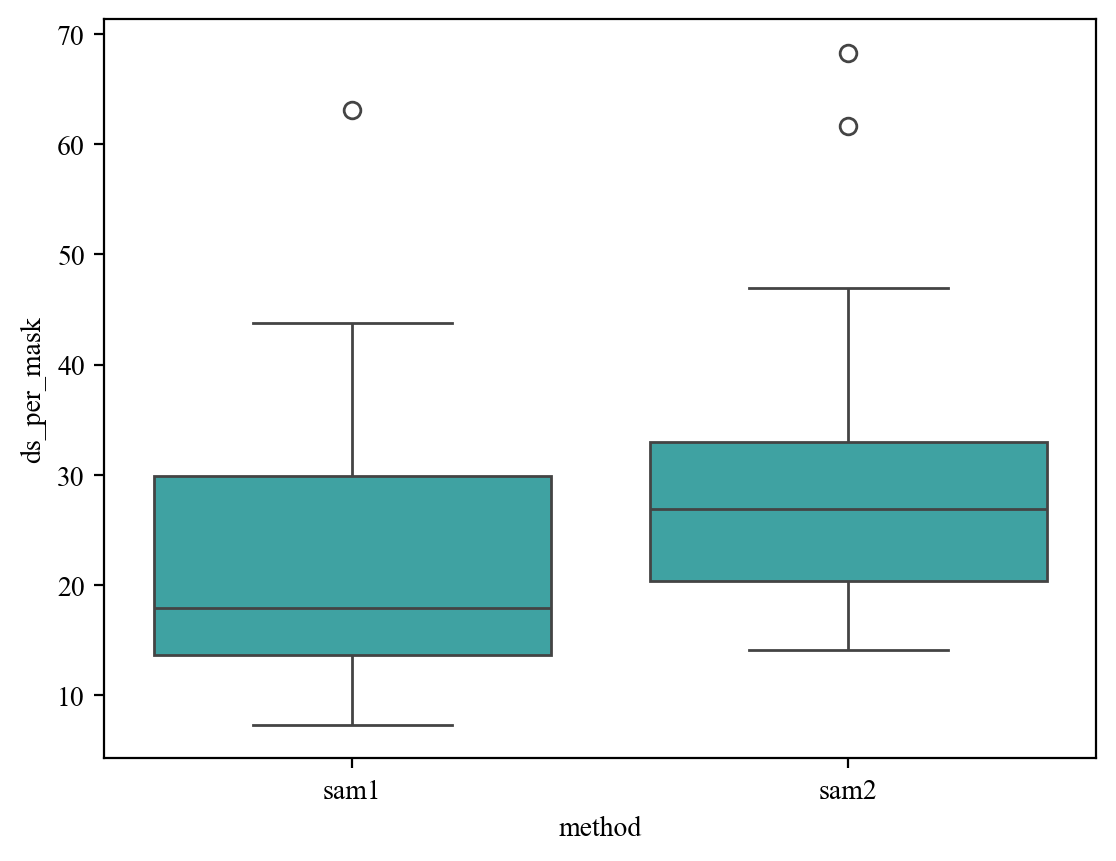

Second Image


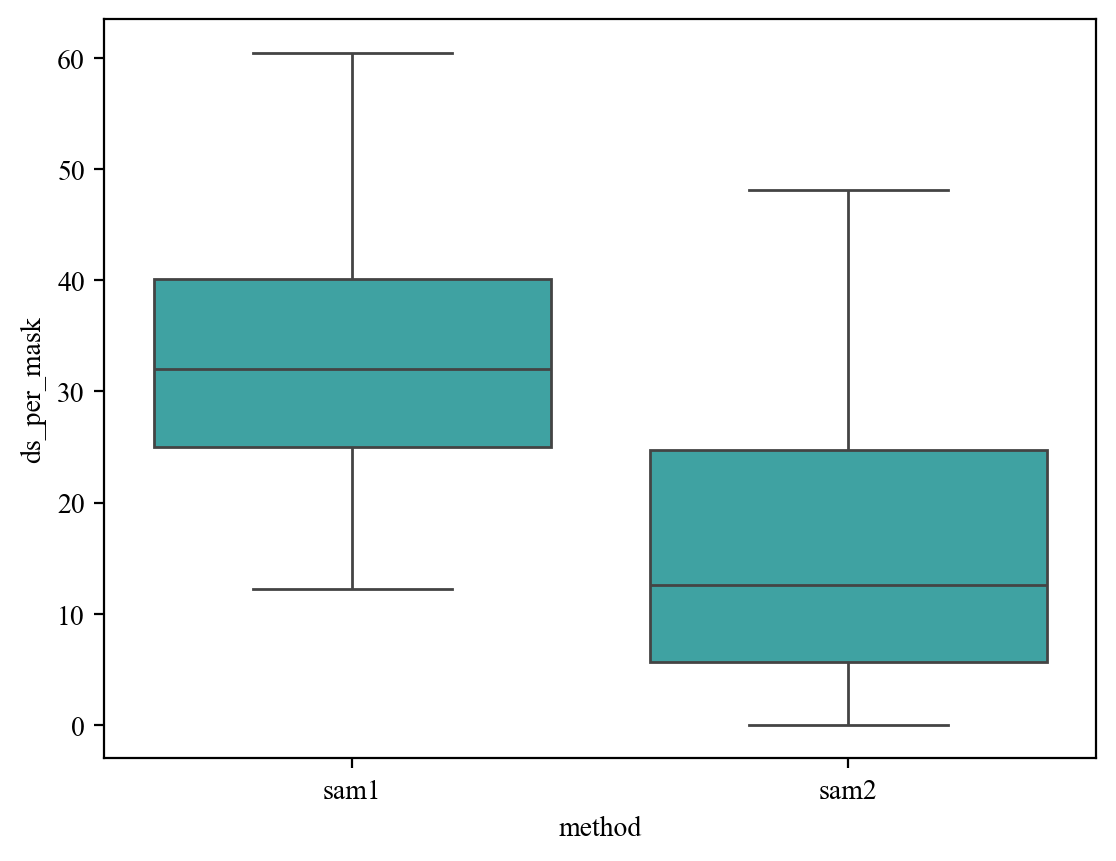

SAM1 - First vs second image


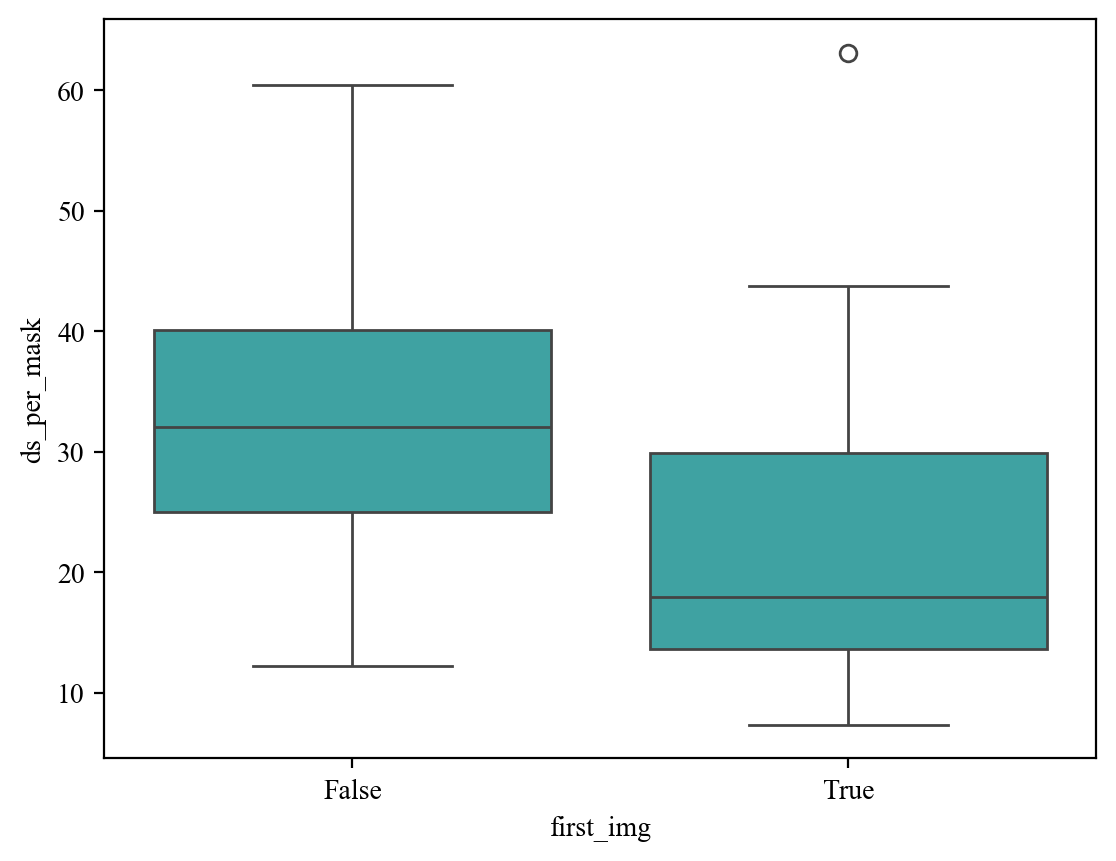

SAM2 - First vs second image


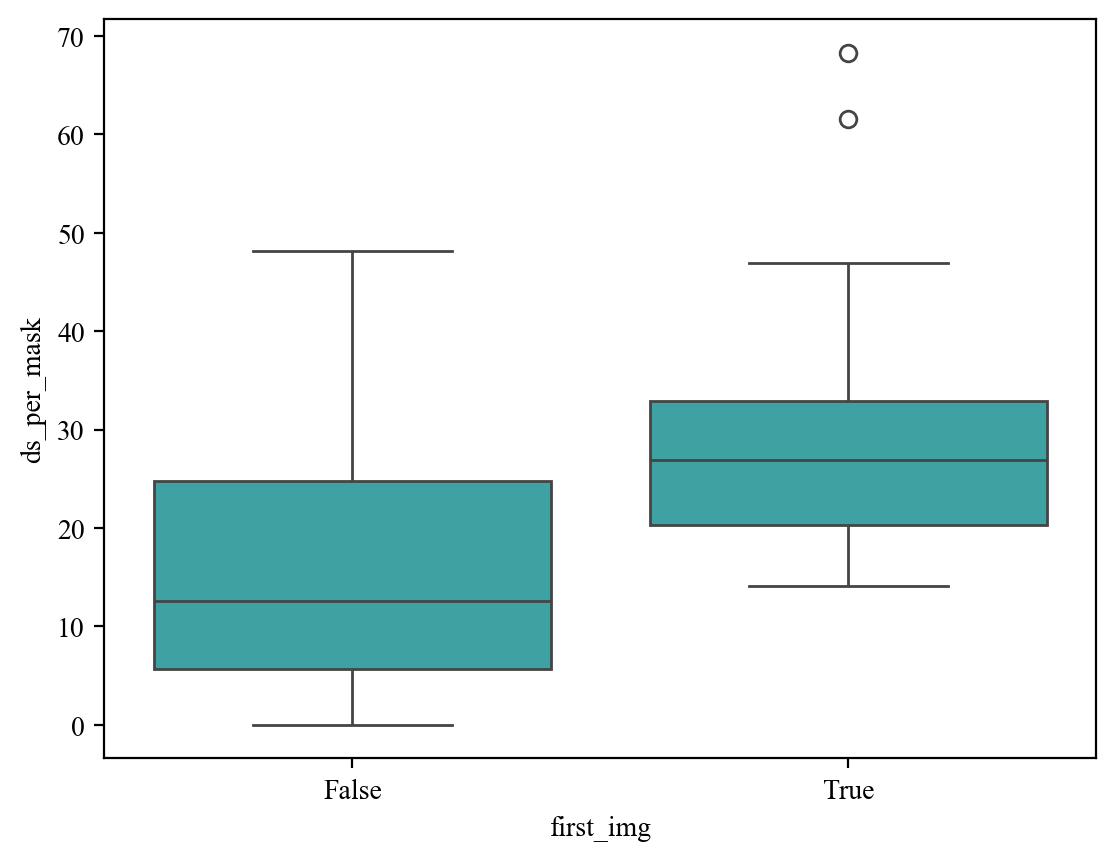

SAM1 first image vs. SAM2 second image


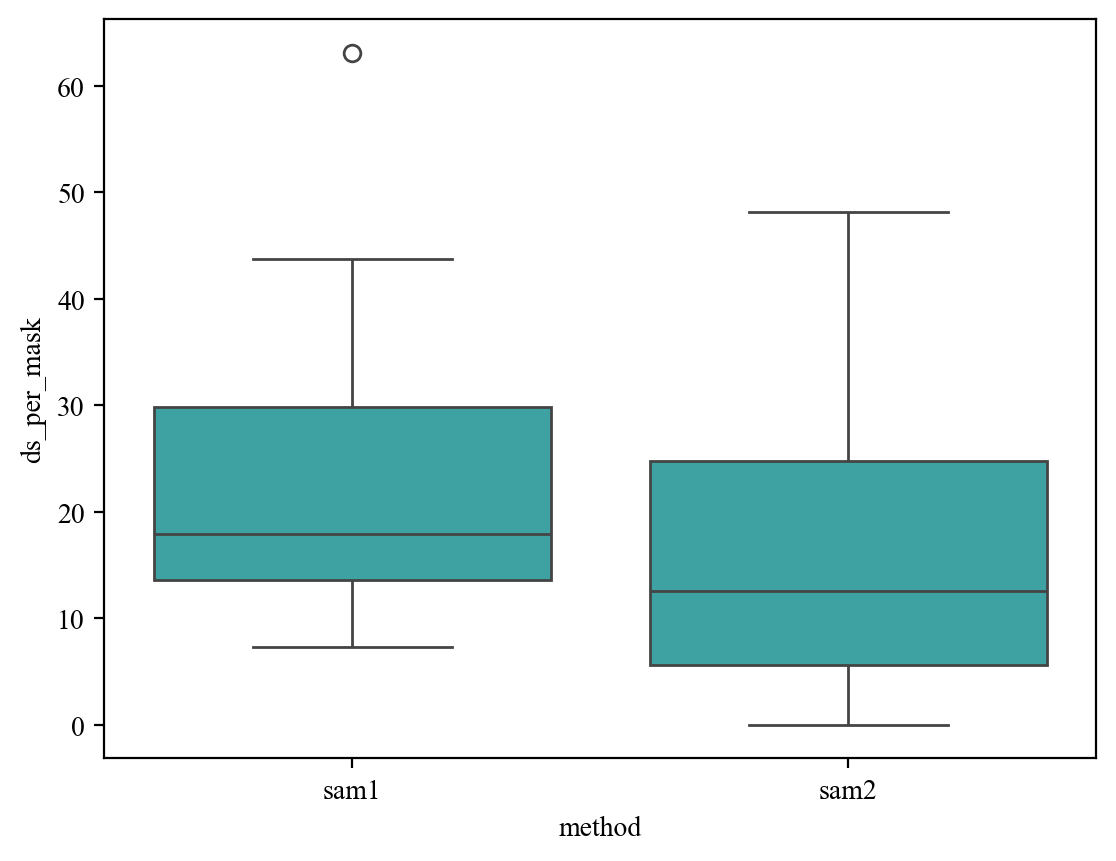

    user_id          ear_id method  ds_per_mask  sam2_tracking_sm  \
1         0  39320223493024   sam2     8.500000                84   
16        1  39320223493024   sam2     0.011111                90   
21        1  39320223525022   sam2     0.014706                68   
46       11  39320223493024   sam2     0.011905                84   
51       11  39320223525022   sam2     0.016129                62   
56       11  39420224413028   sam2     0.008772               114   
61       12  39320223493024   sam2     4.847826                86   
91        5  39320223493024   sam2     7.082474                94   
121       7  39320223493024   sam2     7.621053                86   
161       9  39420224413028   sam2     0.008475               118   
171       2  39320223525022   sam2     6.439394                62   
176       2  39420224413028   sam2     0.008547               117   
181       3  39320223493024   sam2     0.011494                87   
191       3  39420224413028   sam2

In [5]:
print("Mean time per mask over all images and users")
print("Polygon")
print((df_sample.loc[df_sample["method"]=='polygon', "total_time"] / df_sample.loc[df_sample["method"]=='polygon', "total_masks_sm"]).mean())
print("Sam1")
print((df_sample.loc[df_sample["method"]=='sam1', "total_time"] / df_sample.loc[df_sample["method"]=='sam1', "total_masks_sm"]).mean())
print("Sam2")
print((df_sample.loc[df_sample["method"]=='sam2', "total_time"] / df_sample.loc[df_sample["method"]=='sam2', "total_masks_sm"]).mean())
print("-------------------")
print()

print("All methods, first img, Mean per img, Violoin Plot")
get_violin_plot(df_sample.loc[df_sample["first_img"] == True], xkey="method", ykey="ds_per_mask", colour_key=None)
print("All methods, first img, Mean per img, Box Plot")
get_box_plot(df_sample.loc[df_sample["first_img"] == True], xkey="method", ykey="ds_per_mask", colour_key=None)
print("All methods, first img, Mean per img, Swarm Plot")
get_swarm_plot(df_sample.loc[df_sample["first_img"] == True], xkey="method", ykey="ds_per_mask", colour_key="user_id")
get_swarm_plot(df_sample.loc[df_sample["first_img"] == True], xkey="method", ykey="ds_per_mask", colour_key="ear_id")


print("All methods, first img, All  masks, Violoin Plot")
get_violin_plot(df_mask.loc[df_mask["first_img"] == True], xkey="method", ykey="time_delta", colour_key=None)
print("All methods, first img, All  masks, Box Plot")
get_box_plot(df_mask.loc[df_mask["first_img"] == True], xkey="method", ykey="time_delta", colour_key=None)

print('First Image')
get_box_plot(df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["first_img"] == True)], xkey="method", ykey="ds_per_mask", colour_key=None)
print('Second Image')
get_box_plot(df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["first_img"] == False)], xkey="method", ykey="ds_per_mask", colour_key=None)
print("SAM1 - First vs second image")
get_box_plot(df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["method"] == "sam1")], xkey="first_img", ykey="ds_per_mask", colour_key=None)
print("SAM2 - First vs second image")
get_box_plot(df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["method"] == "sam2")], xkey="first_img", ykey="ds_per_mask", colour_key=None)

print("SAM1 first image vs. SAM2 second image")
df_sam1f = df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["method"] == "sam1") & (df_sample["first_img"] == True)]
df_sam2s = df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["method"] == "sam2") & (df_sample["first_img"] == False)]
df_sam1f_sam2s = pd.concat([df_sam1f, df_sam2s])
get_box_plot(df_sam1f_sam2s, xkey="method", ykey="ds_per_mask", colour_key=None)

# check whethter users added maks in the second image at all
df_temp = df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["first_img"] == False)]
print(df_temp.loc[df_temp['ds_per_mask'] < 10., ['user_id', 'ear_id', 'method', 'ds_per_mask', 'sam2_tracking_sm', 'sam2_tracking_am', 'sam2_proposed_sm', 'sam2_interactive_sm']])

